In [1]:
from sklearn.model_selection import train_test_split

In [2]:
import pandas as pd
df=pd.read_csv("creditcard.csv")

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

data contain no null values as it already transformed using PCA

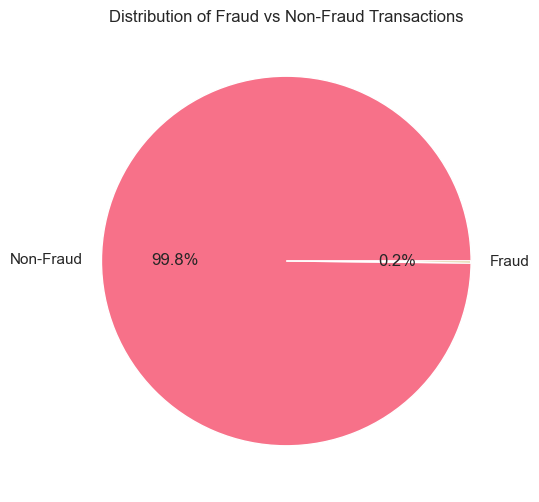

Number of fraud cases: 492
Number of non-fraud cases: 284315


In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Read the data
df = pd.read_csv("creditcard.csv")

# Set style for better visualizations
sns.set_theme(style="whitegrid")
sns.set_palette('husl')

# 1. Class Distribution Analysis
plt.figure(figsize=(10, 6))
class_counts = df['Class'].value_counts()
plt.pie(class_counts, labels=['Non-Fraud', 'Fraud'], autopct='%1.1f%%')
plt.title('Distribution of Fraud vs Non-Fraud Transactions')
plt.show()

print(f"Number of fraud cases: {class_counts[1]}")
print(f"Number of non-fraud cases: {class_counts[0]}")

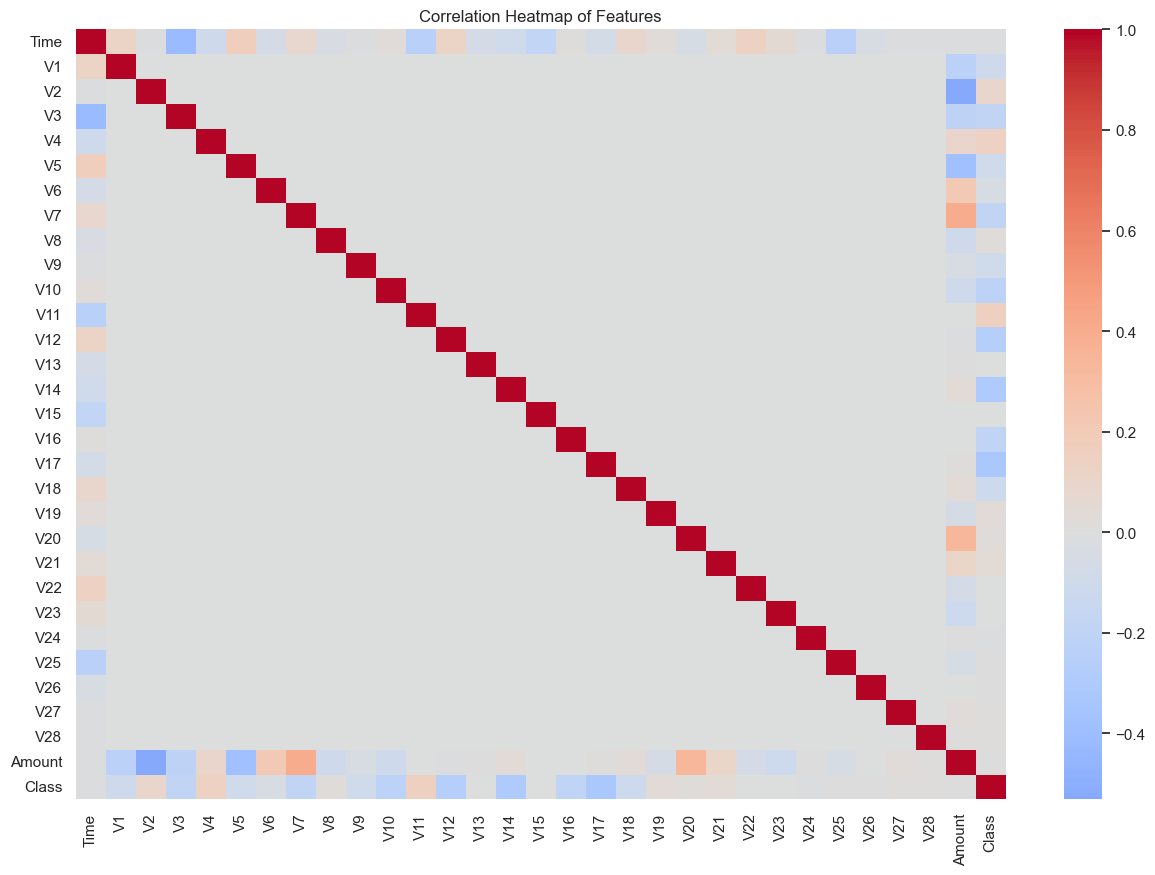

In [8]:
plt.figure(figsize=(15, 10))
correlation_matrix = df.corr()
sns.heatmap(correlation_matrix, cmap='coolwarm', center=0, annot=False)
plt.title('Correlation Heatmap of Features')
plt.show()

In [9]:
print("\nStatistics of Transaction Amount by Class:")
print(df.groupby('Class')['Amount'].describe())


Statistics of Transaction Amount by Class:
          count        mean         std  min   25%    50%     75%       max
Class                                                                      
0      284315.0   88.291022  250.105092  0.0  5.65  22.00   77.05  25691.16
1         492.0  122.211321  256.683288  0.0  1.00   9.25  105.89   2125.87


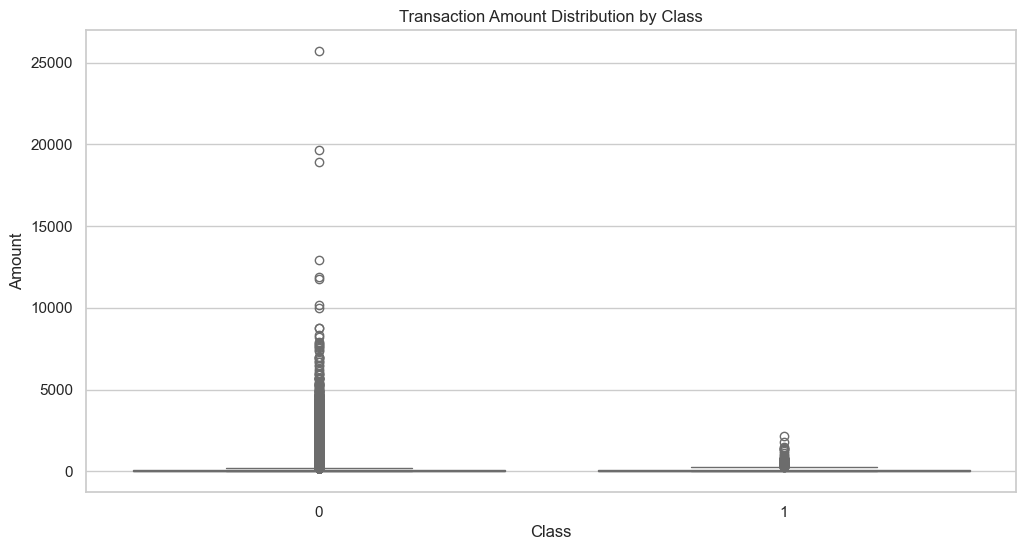

In [12]:
plt.figure(figsize=(12, 6))
sns.boxplot(x='Class', y='Amount', data=df)
plt.title('Transaction Amount Distribution by Class')
plt.show()


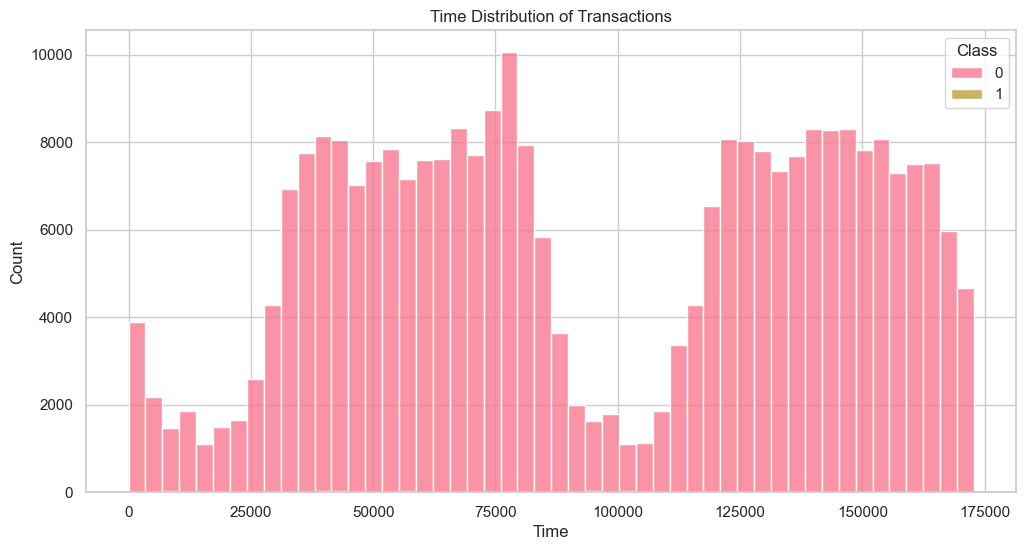

In [13]:
plt.figure(figsize=(12, 6))
sns.histplot(data=df, x='Time', hue='Class', bins=50, multiple='stack')
plt.title('Time Distribution of Transactions')
plt.show()


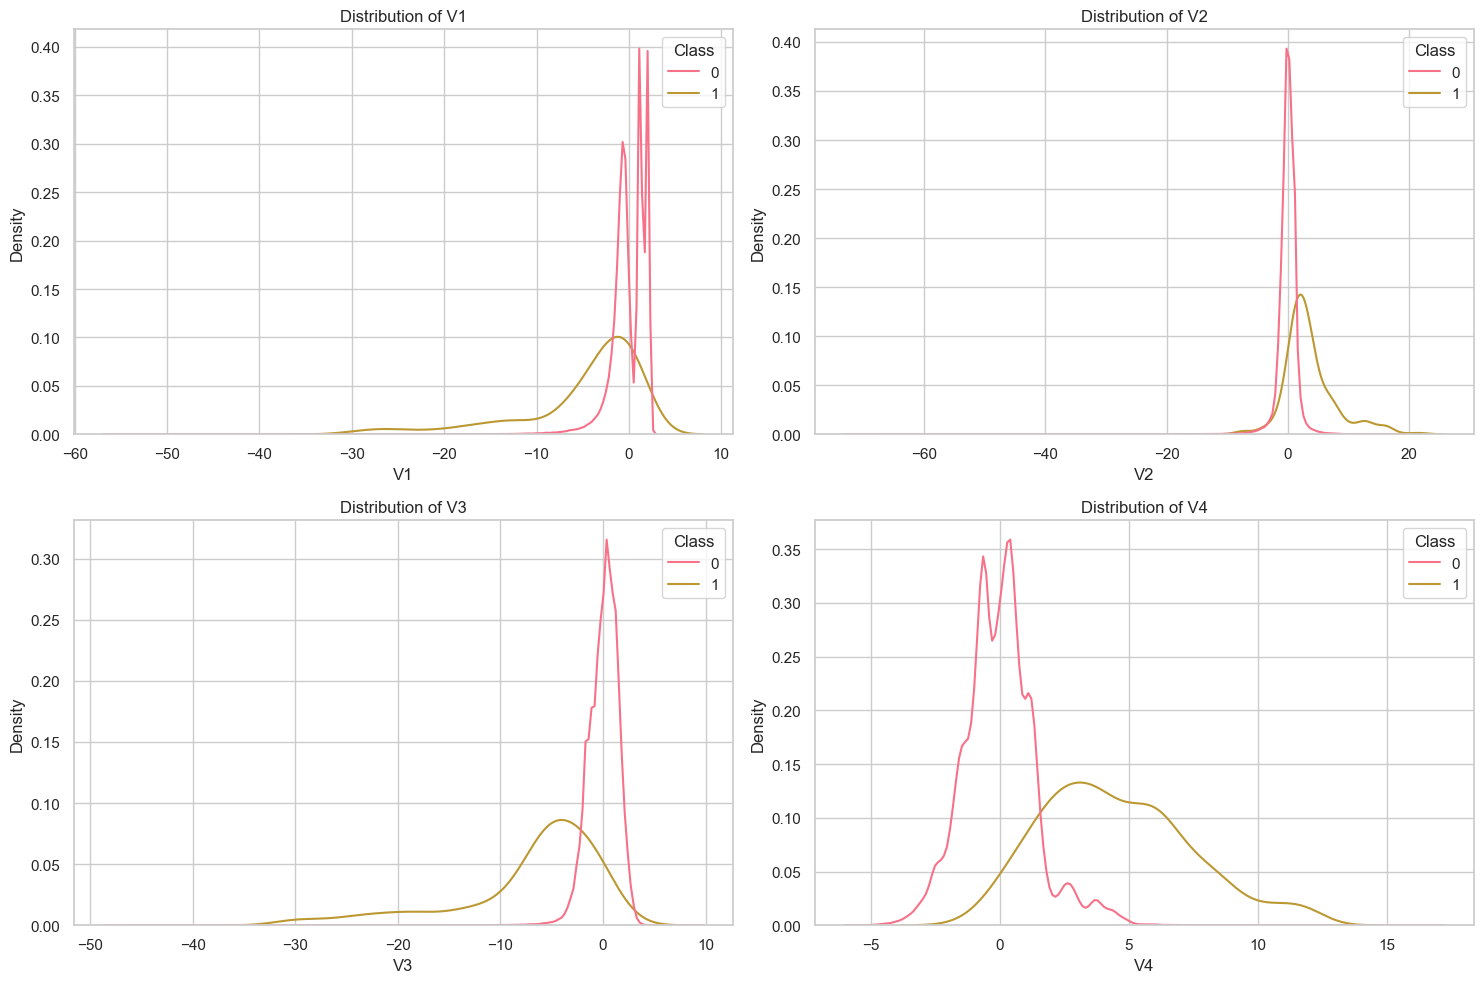

In [14]:
plt.figure(figsize=(15, 10))
for i, feature in enumerate(['V1', 'V2', 'V3', 'V4']):
    plt.subplot(2, 2, i+1)
    sns.kdeplot(data=df, x=feature, hue='Class', common_norm=False)
    plt.title(f'Distribution of {feature}')
plt.tight_layout()
plt.show()

In [16]:
# 8. Check for any potential outliers in Amount
Q1 = df['Amount'].quantile(0.25)
Q3 = df['Amount'].quantile(0.75)
IQR = Q3 - Q1
outliers = df[(df['Amount'] < (Q1 - 1.5 * IQR)) | (df['Amount'] > (Q3 + 1.5 * IQR))]
class_0_outliers = outliers[outliers['Class'] == 0]
class_1_outliers = outliers[outliers['Class'] == 1]

# Print results
print(f"\nTotal number of outliers in 'Amount': {len(outliers)}")
print(f"Number of outliers in Class 0 (Non-Fraud): {len(class_0_outliers)}")
print(f"Number of outliers in Class 1 (Fraud): {len(class_1_outliers)}")


Total number of outliers in 'Amount': 31904
Number of outliers in Class 0 (Non-Fraud): 31813
Number of outliers in Class 1 (Fraud): 91


##creating a base model and will improve it through doing experiments

In [10]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score


In [11]:
df=pd.read_csv("creditcard.csv")
df.drop(columns=['Time'], inplace=True)
X = df.drop('Class', axis=1)
y = df['Class']
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

In [12]:
rf_model = RandomForestClassifier(
    n_estimators=100,
    random_state=42,
    class_weight='balanced' 
)
rf_model.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced', random_state=42)

In [13]:
y_pred = rf_model.predict(X_test)
y_prob = rf_model.predict_proba(X_test)[:, 1] 
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

print(f"\nROC-AUC Score: {roc_auc_score(y_test, y_prob):.4f}")

Confusion Matrix:
[[56861     3]
 [   24    74]]

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.96      0.76      0.85        98

    accuracy                           1.00     56962
   macro avg       0.98      0.88      0.92     56962
weighted avg       1.00      1.00      1.00     56962


ROC-AUC Score: 0.9580


## our model is underfit we go with the boosting and iso_forest anomaly score(adding new feature).

In [16]:
from sklearn.ensemble import IsolationForest
import xgboost as xgb

In [17]:

iso_forest = IsolationForest(contamination=0.0017, random_state=42)
iso_forest.fit(X_train[y_train==0])

X_train_iso = X_train.copy()
X_test_iso = X_test.copy()

X_train_iso['iso_score'] = -iso_forest.decision_function(X_train)
X_test_iso['iso_score'] = -iso_forest.decision_function(X_test)

X_train_iso.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,iso_score
265518,1.946747,-0.752526,-1.355130,-0.661630,1.502822,4.024933,-1.479661,1.139880,1.406819,-0.157403,...,0.076197,0.297537,0.307915,0.690980,-0.350316,-0.388907,0.077641,-0.032248,7.32,-0.244802
180305,2.035149,-0.048880,-3.058693,0.247945,2.943487,3.298697,-0.002192,0.674782,0.045826,0.284864,...,0.038628,0.228197,0.035542,0.707090,0.512885,-0.471198,0.002520,-0.069002,2.99,-0.252040
42664,-0.991920,0.603193,0.711976,-0.992425,-0.825838,1.956261,-2.212603,-5.037523,0.000772,-2.009561,...,-2.798352,0.109526,-0.436530,-0.932803,0.826684,0.913773,0.038049,0.185340,175.10,-0.130998
198723,2.285718,-1.500239,-0.747565,-1.668119,-1.394143,-0.350339,-1.427984,0.010010,-1.118447,1.756121,...,-0.139670,0.077013,0.208310,-0.538236,-0.278032,-0.162068,0.018045,-0.063005,6.10,-0.267052
82325,-0.448747,-1.011440,0.115903,-3.454854,0.715771,-0.147490,0.504347,-0.113817,-0.044782,-0.558955,...,-0.243245,-0.173298,-0.006692,-1.362383,-0.292234,-0.144622,-0.032580,-0.064194,86.10,-0.253419


In [18]:
m=X_train_iso[y_train==1]['iso_score'].mean()

In [19]:
m 

-0.07071716492369097

In [20]:
n=X_train_iso[y_train==0]['iso_score'].mean()

In [21]:
n

-0.25119717304638156

#we can see the difference in the mean of iso_score of the class 0 and 1

#iso_forest able to differentiate between the class 0 and 1.

In [23]:
xgb_model_iso = xgb.XGBClassifier(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=5,
    random_state=42,
    scale_pos_weight=len(y_train[y_train==0])/len(y_train[y_train==1])  
)


xgb_model_iso.fit(X_train_iso, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, random_state=42, ...)


Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.51      0.86      0.64        98

    accuracy                           1.00     56962
   macro avg       0.76      0.93      0.82     56962
weighted avg       1.00      1.00      1.00     56962



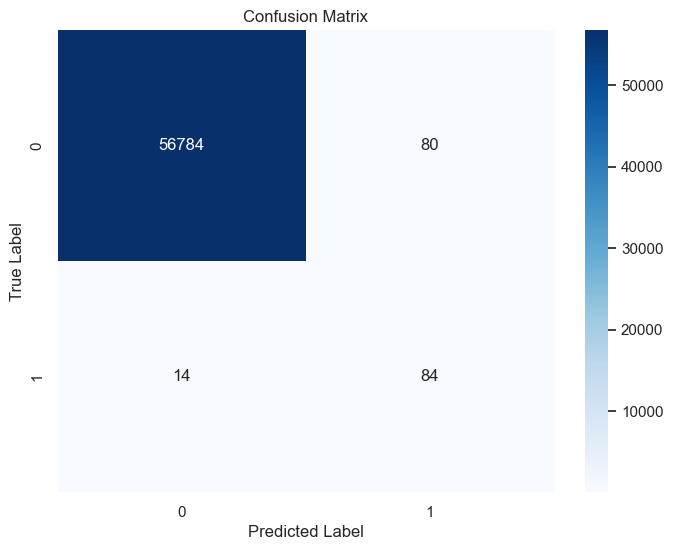


ROC-AUC Score: 0.9768


In [25]:
y_pred = xgb_model_iso.predict(X_test_iso)
y_prob = xgb_model_iso.predict_proba(X_test_iso)[:, 1] 


# Print classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Plot confusion matrix
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()
print(f"\nROC-AUC Score: {roc_auc_score(y_test, y_prob):.4f}")

#### will go with same strategy as before+ SMOTE which will increaae our data point of class 1

In [65]:
from imblearn.over_sampling import SMOTE
df=pd.read_csv("creditcard.csv")
df.drop(columns=['Time'], inplace=True)
X = df.drop('Class', axis=1)
y = df['Class']
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

iso_forest = IsolationForest(contamination=0.0017, random_state=42)
iso_forest.fit(X_train[y_train == 0])
print(f"here is the sahpe for iso_train{X_train.shape}")

X_train['iso_score'] = -iso_forest.decision_function(X_train)
X_test['iso_score'] = -iso_forest.decision_function(X_test)


target_ratio = 0.02  
minority = sum(y_train == 1)
majority = sum(y_train == 0)
target_minority_count = int(target_ratio * majority)

sampling_strategy = (target_minority_count / minority)/100
print(sampling_strategy)
smote = SMOTE(sampling_strategy=sampling_strategy, random_state=42)
X_train_sm, y_train_sm = smote.fit_resample(X_train, y_train)

columns = X_train.columns
X_train_sm_df = pd.DataFrame(X_train_sm, columns=columns)
y_train_sm_df = pd.Series(y_train_sm, name="Class")

df_train_smote = pd.concat([X_train_sm_df, y_train_sm_df], axis=1)

# Save or return
print(f"Shape after SMOTE: {df_train_smote.shape}")
print(df_train_smote['Class'].value_counts(normalize=True))

df_train_smote.head()


print(f"Number of fraud cases: {df_train_smote['Class'].value_counts()[1]}")
print(f"Number of non-fraud cases: {df_train_smote['Class'].value_counts()[0]}")



here is the sahpe for iso_train(227845, 29)
0.11545685279187817
Shape after SMOTE: (253711, 31)
Class
0    0.896496
1    0.103504
Name: proportion, dtype: float64
Number of fraud cases: 26260
Number of non-fraud cases: 227451


In [56]:
import joblib

joblib.dump(iso_forest, 'iso_forest_model.pkl')

['iso_forest_model.pkl']

In [57]:
X_train_smote = df_train_smote.drop('Class', axis=1)
y_train_smote = df_train_smote['Class']

In [58]:
import xgboost as xgb
xgb_model_smote_iso = xgb.XGBClassifier(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=5,
    random_state=42,
    scale_pos_weight=len(y_train[y_train==0])/len(y_train[y_train==1])  
)


xgb_model_smote_iso.fit(X_train_smote, y_train_smote)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, random_state=42, ...)


Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.98      0.99     56864
           1       0.07      0.91      0.13        98

    accuracy                           0.98     56962
   macro avg       0.54      0.94      0.56     56962
weighted avg       1.00      0.98      0.99     56962



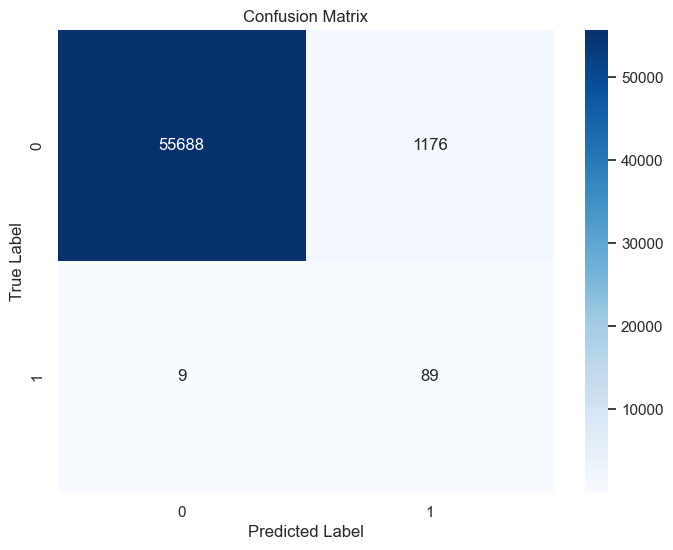


ROC-AUC Score: 0.9736


In [59]:
from sklearn.metrics import classification_report, confusion_matrix
y_pred = xgb_model_smote_iso.predict(X_test_iso)
y_prob = xgb_model_smote_iso.predict_proba(X_test_iso)[:, 1] 


print("\nClassification Report:")
print(classification_report(y_test, y_pred))

plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()
print(f"\nROC-AUC Score: {roc_auc_score(y_test, y_prob):.4f}")

In [60]:
import joblib

joblib.dump(xgb_model_smote_iso, 'xgb_model_smote_iso.pkl')

['xgb_model_smote_iso.pkl']

In [61]:
X_train

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,iso_score
265518,1.946747,-0.752526,-1.355130,-0.661630,1.502822,4.024933,-1.479661,1.139880,1.406819,-0.157403,...,0.076197,0.297537,0.307915,0.690980,-0.350316,-0.388907,0.077641,-0.032248,7.32,-0.244802
180305,2.035149,-0.048880,-3.058693,0.247945,2.943487,3.298697,-0.002192,0.674782,0.045826,0.284864,...,0.038628,0.228197,0.035542,0.707090,0.512885,-0.471198,0.002520,-0.069002,2.99,-0.252040
42664,-0.991920,0.603193,0.711976,-0.992425,-0.825838,1.956261,-2.212603,-5.037523,0.000772,-2.009561,...,-2.798352,0.109526,-0.436530,-0.932803,0.826684,0.913773,0.038049,0.185340,175.10,-0.130998
198723,2.285718,-1.500239,-0.747565,-1.668119,-1.394143,-0.350339,-1.427984,0.010010,-1.118447,1.756121,...,-0.139670,0.077013,0.208310,-0.538236,-0.278032,-0.162068,0.018045,-0.063005,6.10,-0.267052
82325,-0.448747,-1.011440,0.115903,-3.454854,0.715771,-0.147490,0.504347,-0.113817,-0.044782,-0.558955,...,-0.243245,-0.173298,-0.006692,-1.362383,-0.292234,-0.144622,-0.032580,-0.064194,86.10,-0.253419
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
233802,1.993864,-0.516866,-0.620118,0.129845,-0.285128,0.395044,-0.822358,0.231591,0.995898,0.212619,...,0.262526,0.884510,0.099141,0.275689,-0.195404,0.623598,-0.032455,-0.058552,5.99,-0.288227
85418,-1.497933,0.657921,1.581568,-0.024286,0.584698,1.303031,0.609212,0.135561,0.452745,0.108640,...,-0.072452,0.299172,0.110048,-0.615980,-0.425883,0.263968,-0.448445,0.045178,36.99,-0.252653
29062,1.069777,0.072105,0.496540,1.505318,-0.380277,-0.370243,0.100551,-0.026687,0.319684,-0.131553,...,-0.061991,-0.044629,-0.050485,0.400171,0.593314,-0.335160,0.031014,0.024886,45.42,-0.294355
13766,1.280465,0.300586,0.333044,0.512720,0.065052,-0.145844,-0.145519,-0.091833,1.111187,-0.268878,...,-0.409934,-0.961351,0.033153,-0.560429,0.278428,0.089546,-0.059835,-0.005887,0.89,-0.264371


In [66]:
row = df.drop(columns=['Class']).iloc[56]
result=df_train_smote.iloc[30]['Class']
payload = row.tolist()
print(payload)
print(len(payload))
print(result)

[-0.554064564931988, 0.215728297966379, 0.84426462904462, -0.753067316254495, 0.0348484695858477, -0.558597247605412, 1.09040095790026, -0.203873231509391, 0.262393622286028, -1.35471021992455, -0.0948798795631494, 0.953745991690559, 0.836964039089714, 0.14475220028962, 1.15660953164838, -1.933020942756, 0.741348957532257, -0.513609928080678, 1.5673453867025, 0.383282932954218, 0.212133973378933, 0.702337604074802, -0.0057006020965723, 0.147346442427205, 0.245651952176691, -0.440456209881165, 0.147130419245981, 0.13946773165502, 120.96]
29
0.0


In [63]:
df.head()
df.shape

(284807, 30)